In [29]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from scipy import stats
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
!pip install xlsxwriter
pd.options.mode.chained_assignment = None  # default='warn'
import statsmodels.api as sm
from statsmodels.formula.api import ols
## https://www.kaggle.com/code/alexmaszanski/two-way-anova-with-python/notebook
import glob
import researchpy as rp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import re
import nbimporter
from sklearn.decomposition import PCA
from two_way_ANOVA_test import read_csvs_to_dict, concat_plates, remove_mean_SEM, rename_row_names
currdir = os.getcwd()
parent = os.path.dirname(currdir)
gparent = os.path.dirname(parent)


In [30]:
bicucilinDIV19= f"{parent}/data/Div19_Bicucilin/"

lines_to_skip = 10 # adjust this as necessary

# count the number of header lines
header_lines = 3 # adjust this as necessary

plate_type = 'DIV19'
# read the csv file into a pandas DataFrame, skipping the metadata at the top
# df = pd.read_csv(filename, skiprows=lines_to_skip, header=[i for i in range(header_lines)])
### read all data

PERTURBATION = "Bicucilin"
firstTableHeading = "Mean Firing Rate (Hz)"

In [31]:
doses = {}

# List all entries in the base directory
for folder in os.listdir(bicucilinDIV19):
    # Construct the full path
    full_path = os.path.join(bicucilinDIV19, folder)
    plates_d = read_csvs_to_dict(full_path, lines_to_skip)
    testparams_d =  concat_plates(plates_d, firstTableHeading)
    messy_d = remove_mean_SEM(testparams_d, folder.split("_")[-1])
    cleaned_d = {key: rename_row_names(df) for key, df in messy_d.items()}
    doses[folder] = cleaned_d
doses.keys()

dict_keys(['Div19_2uMbicucilin', 'Div19_6uMbicucilin', 'Div19_26uMbicucilin', 'Div19_basal'])

In [32]:
## concatenate all tests for PCA
doses_concat = {}

for folder, test_dict in doses.items():
    folder_dfs = []  # List to store all DataFrames in the current folder
    
    for test, df in test_dict.items():
        # Rename columns to include the test name as suffix
        df = df.rename(columns={col: col + "_" + test for col in df.columns})
        folder_dfs.append(df)

    # Concatenate all DataFrames in the current folder
    if folder_dfs:
        doses_concat[folder] = pd.concat(folder_dfs, axis=1) ## concatenate along rows
doses_concat['Div19_2uMbicucilin']

,GPR37L 1_Mean Firing Rate (Hz),GPR37L 2_Mean Firing Rate (Hz),LGI2 A12_Mean Firing Rate (Hz),SLITRK5_Mean Firing Rate (Hz),THSD7 1_Mean Firing Rate (Hz),THSD7 2_Mean Firing Rate (Hz),unt1_Mean Firing Rate (Hz),unt2_Mean Firing Rate (Hz),Chemical_Type_Mean Firing Rate (Hz),GPR37L 1_Number of Active Electrodes,...,Chemical_Type_Network Normalized Duration IQR,GPR37L 1_Area Under Normalized Cross-Correlation,GPR37L 2_Area Under Normalized Cross-Correlation,LGI2 A12_Area Under Normalized Cross-Correlation,SLITRK5_Area Under Normalized Cross-Correlation,THSD7 1_Area Under Normalized Cross-Correlation,THSD7 2_Area Under Normalized Cross-Correlation,unt1_Area Under Normalized Cross-Correlation,unt2_Area Under Normalized Cross-Correlation,Chemical_Type_Area Under Normalized Cross-Correlation
Replicate1,3.221134,1.547937,5.770529,5.530013,7.351188,6.718424,4.522926,3.767820,2uMbicucilin,8.000000,...,2uMbicucilin,0.773048,0.736251,0.905777,0.772396,0.916680,0.863456,0.826059,0.869351,2uMbicucilin
Replicate2,4.029804,5.520425,3.074823,8.867236,2.021884,8.123385,3.739892,3.773030,2uMbicucilin,7.000000,...,2uMbicucilin,0.763942,0.746149,0.822716,0.918022,0.867832,0.927573,0.848726,0.969547,2uMbicucilin
Replicate3,5.655273,2.629846,5.165902,3.267820,5.348479,5.224260,4.859525,3.739266,2uMbicucilin,8.000000,...,2uMbicucilin,0.830372,0.777883,0.873479,0.575698,0.963773,0.692872,0.823029,0.709152,2uMbicucilin
Replicate4,7.150063,7.088162,5.996665,9.885369,4.920800,5.144227,7.179658,7.844935,2uMbicucilin,8.000000,...,2uMbicucilin,0.853182,0.895295,0.900306,0.851840,0.827123,0.823385,0.901244,0.948145,2uMbicucilin
Replicate5,7.085869,4.214048,3.699875,4.829721,3.089204,4.423510,6.351396,10.242184,2uMbicucilin,8.000000,...,2uMbicucilin,0.864270,0.783082,0.959260,0.845335,0.771494,0.738831,0.852855,0.928139,2uMbicucilin
Replicate6,3.729262,0.557316,4.309296,10.847228,5.396415,8.403085,5.463526,16.993331,2uMbicucilin,8.000000,...,2uMbicucilin,0.926760,0.762009,0.778528,0.814385,0.936838,0.832486,0.840517,0.929400,2uMbicucilin
Replicate7,8.591080,2.840975,1.729054,6.508754,3.966861,4.871822,5.870571,6.632555,2uMbicucilin,8.000000,...,2uMbicucilin,0.938962,0.923511,0.826493,0.865669,0.790510,0.989307,0.878405,0.918520,2uMbicucilin
Replicate8,7.500417,5.750313,3.814506,6.208629,6.391205,6.986453,9.863902,6.288037,2uMbicucilin,8.000000,...,2uMbicucilin,0.931374,0.938988,0.899212,0.882326,0.902561,0.936717,0.912090,0.878330,2uMbicucilin
Replicate9,3.348479,8.566694,2.761150,6.517090,9.319300,6.290538,12.347853,5.630888,2uMbicucilin,8.000000,...,2uMbicucilin,0.830590,0.842362,0.726211,0.905190,0.815390,0.912189,0.890618,0.902533,2uMbicucilin
Replicate10,6.674239,10.189246,4.482910,13.437682,3.783035,7.996248,7.945602,4.262818,2uMbicucilin,8.000000,...,2uMbicucilin,0.876468,0.822380,0.860600,0.858398,0.905324,0.899576,0.880270,0.814019,2uMbicucilin


In [45]:
## standardize the data 
bicu26uM = doses_concat['Div19_26uMbicucilin']
basal = doses_concat['Div19_basal']
standardized = {}
for dose,df in doses_concat.items():
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='ignore')

    df = df.select_dtypes(include=[np.number])  # Select only numeric columns
    df.fillna(0, inplace=True) ## try imputing
    standardized[dose] = StandardScaler().fit_transform(df) ## yields array


In [50]:
pca = PCA(n_components=10)
bicu26uM_pca = pca.fit_transform(standardized['Div19_26uMbicucilin'])
basal_pca = pca.fit_transform(standardized['Div19_basal'])


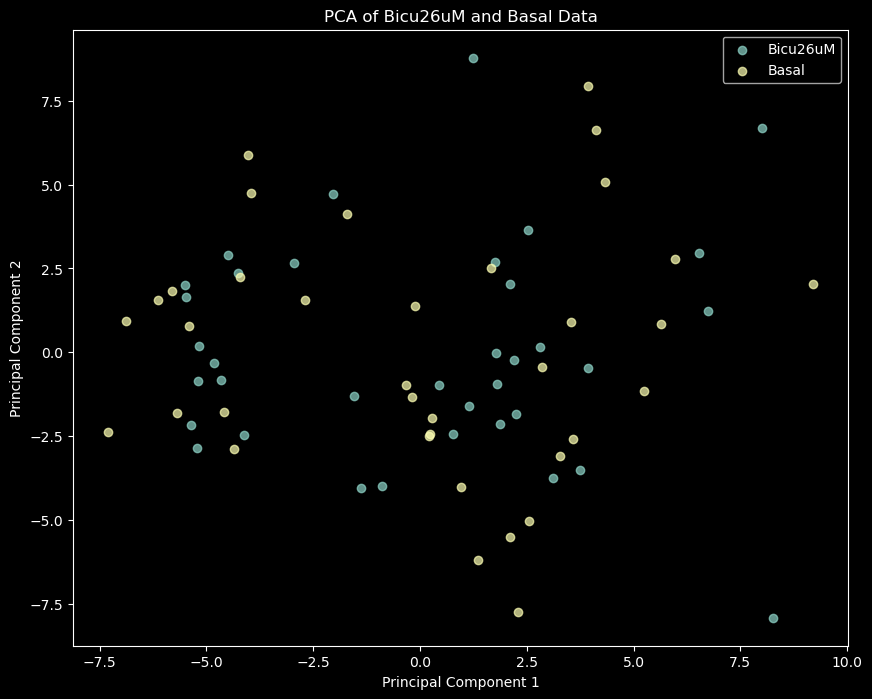

In [51]:

# Assuming bicu26uM_pca and basal_pca are your PCA-transformed data
# Create a scatter plot
plt.figure(figsize=(10, 8))

# Plotting bicu26uM
plt.scatter(bicu26uM_pca[:, 0], bicu26uM_pca[:, 1], alpha=0.7, label='Bicu26uM')

# Plotting basal
plt.scatter(basal_pca[:, 0], basal_pca[:, 1], alpha=0.7, label='Basal')

# Adding title and labels
plt.title('PCA of Bicu26uM and Basal Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Adding legend
plt.legend()

# Show plot
plt.show()

In [34]:
doses_concat['Div19_basal']

,GPR37L 1_Mean Firing Rate (Hz),GPR37L 2_Mean Firing Rate (Hz),LGI2 A12_Mean Firing Rate (Hz),SLITRK5_Mean Firing Rate (Hz),THSD7 1_Mean Firing Rate (Hz),THSD7 2_Mean Firing Rate (Hz),unt1_Mean Firing Rate (Hz),unt2_Mean Firing Rate (Hz),GPR37L 1_Number of Active Electrodes,GPR37L 2_Number of Active Electrodes,...,unt1_Resistance - Avg (kOhms),unt2_Resistance - Avg (kOhms),GPR37L 1_Number of Covered Electrodes,GPR37L 2_Number of Covered Electrodes,LGI2 A12_Number of Covered Electrodes,SLITRK5_Number of Covered Electrodes,THSD7 1_Number of Covered Electrodes,THSD7 2_Number of Covered Electrodes,unt1_Number of Covered Electrodes,unt2_Number of Covered Electrodes
Replicate1,1.827421,3.278172,5.325334,3.735184,0.840568,3.100167,3.665484,2.135017,8.000000,7.000000,...,37.824664,39.356888,8.000000,7.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
Replicate2,0.901503,6.809265,0.281511,1.074499,4.000626,3.151920,3.726210,1.878548,8.000000,8.000000,...,40.920260,47.525149,8.000000,8.000000,8.000000,7.000000,8.000000,8.000000,7.000000,8.000000
Replicate3,7.349958,2.711603,1.391903,2.271077,2.575334,2.032137,7.272120,2.567195,7.000000,8.000000,...,43.606752,44.809401,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
Replicate4,1.503130,2.224958,1.152129,4.904215,0.460559,1.641068,5.093907,7.638564,7.000000,8.000000,...,40.994951,42.562915,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
Replicate5,2.211811,3.282137,1.718907,4.165275,3.251043,0.664441,4.756469,1.001461,8.000000,8.000000,...,42.936886,45.582911,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,6.000000,8.000000
Replicate6,0.859349,1.075960,0.144616,2.927588,2.784850,0.998122,7.111853,2.213063,7.000000,7.000000,...,41.420544,41.511833,8.000000,8.000000,3.000000,8.000000,8.000000,8.000000,8.000000,8.000000
Replicate7,1.724332,4.111853,1.263982,3.683848,1.036519,1.958890,7.449290,4.388356,7.000000,8.000000,...,36.383801,40.434245,8.000000,6.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
Replicate8,4.589942,5.143573,2.862270,9.942821,0.817613,3.272538,4.589733,2.458890,5.000000,6.000000,...,39.921924,42.858247,8.000000,7.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
Replicate9,1.027337,1.117696,1.815109,3.771077,1.239149,1.111227,5.449917,1.208890,7.000000,7.000000,...,39.179358,39.319977,8.000000,8.000000,7.000000,8.000000,8.000000,8.000000,8.000000,8.000000
Replicate10,1.507930,0.885434,3.836603,3.796953,0.921953,0.662771,10.533389,1.662771,8.000000,7.000000,...,38.876925,38.548983,8.000000,8.000000,7.000000,8.000000,8.000000,8.000000,8.000000,8.000000
